In [1]:
#Extracting file

import os
import zipfile

with zipfile.ZipFile('Alzheimer.zip', 'r') as zip_file:
    zip_file.extractall("./")

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
path_train = "/content/Alzheimer_s Dataset/train"
path_test = "/content/Alzheimer_s Dataset/test"

train_rescale = ImageDataGenerator(rescale=1./255)
test_rescale = ImageDataGenerator(rescale=1./255)

train_data = train_rescale.flow_from_directory(
    path_train,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)


test_data = test_rescale.flow_from_directory(
    path_test,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
# Define the input shape for grayscale images
input_shape = (224, 224, 1)

# Load the InceptionV3 model without the top layers and specify the input shape
base_model = InceptionV3(weights=None, include_top=False, input_tensor=Input(shape=input_shape))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(train_data.num_classes, activation='softmax')(x)

# Define the full model
inception_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Train the model
history = inception_model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 167s 516ms/step - accuracy: 0.5304 - loss: 1.0041 - val_accuracy: 0.3503 - val_loss: 1.2237
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.6202 - loss: 0.8242 - val_accuracy: 0.5004 - val_loss: 3.6410
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.6990 - loss: 0.7007 - val_accuracy: 0.5020 - val_loss: 1.5263
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 238ms/step - accuracy: 0.7677 - loss: 0.5594 - val_accuracy: 0.5262 - val_loss: 1.2053
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.8411 - loss: 0.4107 - val_accuracy: 0.4762 - val_loss: 1.5190
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.8858 - loss: 0.2936 - val_accuracy: 0.5825 - val_loss: 2.2957
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.9251 - loss: 0.1861 - val_accuracy: 0.5645 - val_loss: 2.1429
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.9443 - loss: 

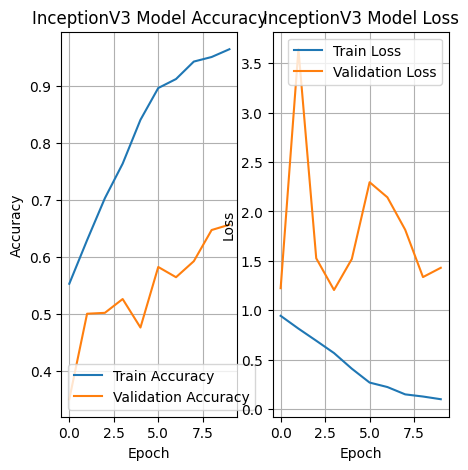

In [12]:
# Plot the training history
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [10]:
test_loss, test_acc = inception_model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6534 - loss: 1.4440
Test Loss: 1.4300283193588257
Test Accuracy: 0.6567630767822266


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the classes on the test set
predictions = inception_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())
print(class_report)

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step
[[ 28   2  77  72]
 [  2   0   6   4]
 [ 91  25 306 218]
 [ 73  16 221 138]]
                  precision    recall  f1-score   support

    MildDemented       0.14      0.16      0.15       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.48      0.49       640
VeryMildDemented       0.32      0.31      0.31       448

        accuracy                           0.37      1279
       macro avg       0.24      0.24      0.24      1279
    weighted avg       0.38      0.37      0.38      1279

